In [1]:
import pandas as pd
import dateutil.parser
import re
import numpy as np

In [2]:
df = pd.read_csv('../Created CSVs/all_seins_all_data_standard_dates.csv')

In [3]:
df['Date'] =  [dateutil.parser.parse(date) for date in list(df['Date'])]

In [4]:
def fix_ph(pH_li):
    pH_list  = []
    pH_li = pH_li.fillna('')
    pH_lists  = [re.findall('\d+\.*', x ) for x in pH_li]

    for pH in pH_lists:
        if len(pH) == 0:
            pH_list.append(np.NaN)
        elif len(pH) ==  1:
            pH_list.append(pH[0])
            #print pH[0]
        elif pH[0][-1] == '.':
            pH_list.append(pH[0]+pH[1])
            #print pH[0]+pH[1]
        else:
            pH_list.append(pH[0])
            #print 'bad',pH[1], pH
    #pHCompare['pH'] = pH_list
    return [float(x) for x in pH_list]

In [5]:
df['Corrected pH'] = fix_ph(df['pH'])

In [6]:
def fix_water_temp(h20_temp_list):
    water_temp_list = []
    h20_temp_list = h20_temp_list.fillna('')
    h20_temp_list  = [re.findall('\d+\.*', x ) for x in h20_temp_list]
    for temp in h20_temp_list:
        #print temp
        if len(temp) == 0:
            water_temp_list.append(np.NaN)
        elif len(temp) ==  1:
            if int(temp[0]) < 30:
                new_temp = int(temp[0]) * 9.0/5 + 32
                water_temp_list.append(str(new_temp))
            else:
                water_temp_list.append(temp[0])
            #print pH[0]
        elif temp[0][-1] == '.':
            water_temp_list.append(temp[0]+temp[1])
            #print pH[0]+pH[1]
        else:
            water_temp_list.append(temp[0])
    
    return [float(x) for x in water_temp_list]

In [7]:
df["Corrected Water Temp:"] = fix_water_temp(df['Water Temp:'])

In [8]:
def fix_salinity(sal_list):
    salinity = []
    for sal in sal_list:
        if sal != sal:
            salinity.append(sal)
        elif any(char.isdigit() for char in sal) == False:
            salinity.append(np.NAN)
        else:
            first_num  = re.search(r'\d+', sal).group()
            salinity.append(first_num)
    return [float(x) for x in salinity]

In [9]:
df['Corrected Salinity'] = fix_salinity(df['Salinity'])

In [10]:
def fix_DO(DO_list):
    cleaned_list = []
    DO_list = DO_list.fillna('')
    DO_list  = [re.findall('\d+\.*', x ) for x in DO_list]

    for DO in DO_list:
        if len(DO) == 0:
            cleaned_list.append(np.NaN)
        else:
            cleaned_list.append(float(DO[0]))
       
    return cleaned_list

In [11]:
#df[df["DO"] == "4.5"]

In [12]:
#set(df['DO'])

In [13]:
df['Corrected DO'] = fix_DO(df['DO'])

In [14]:
df['Corrected Quantity'] = df['Quantity'].fillna(1)

In [15]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [16]:
def fix_quantity(quant_list):
    num_caught_list = []
    for num in list(quant_list):
        if type(num) ==  int:
            num_caught_list.append(num)
        elif is_number(num):
            num_caught_list.append(int(float(num)))
        else:
            number = ''
            started = False
            for char in num:
                if char.isdigit():
                    number += char
                    started = True
                else:
                    if char == '~':
                        print started
                    if started:
                        break
            if len(number):
                num_caught_list.append(int(number))
            else:
                if num in ['Numerous', 'TMTC', 'Too Many To Count']:
                    num_caught_list.append(30)
                else:
                    num_caught_list.append(1)
    return num_caught_list

In [17]:
df['Corrected Quantity'] = fix_quantity(df['Corrected Quantity'])

False
False
False


In [18]:
def fix_hauls(hauls_li):
    #?, Many, and Unknown have all been gotten rid of and not replaced by a number.
    clean_hauls = []
    for haul in hauls_li:
        if haul != haul:
            clean_hauls.append(np.nan)
        elif any(char.isdigit() for char in haul):
            first_num  = re.search(r'\d+', haul).group()
            clean_hauls.append(first_num)
        else:
            clean_hauls.append(np.nan)
    return clean_hauls

In [19]:
df['Corrected # Hauls'] = fix_hauls(df['# Hauls'])

In [20]:
remove_row_list = ['two hemigrapsis molts were found on the beach', 'species caught', 'slipper snail shell', 'slipper snail shell', 'slipper shell', 'oyster shell','hemigraphis molt']

In [21]:
fish_list = [re.sub(r'([^\s\w]|_)+', '', f) for f in df['Common Name']]
fish_list = [f.lower() for f in fish_list]
fish_list = [f.strip() for f in fish_list]

In [22]:
df['Common Name'] = fish_list

In [23]:
df = df[df['Common Name'].isin(remove_row_list) == False]

In [24]:
df = df.reset_index()

In [25]:
fish_list = [f.replace('yoy', '') for f in df['Common Name']]

In [26]:
from difflib import SequenceMatcher

In [27]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [28]:
count = 0
fish_changes = []
for i in range(len(fish_list)):
    for j in range(i+1, len(fish_list)):
        if fish_list[i] ==  fish_list[j]:
            continue
        if similar(fish_list[i], fish_list[j]) > 0.85:
            fish_changes.append([fish_list[i], fish_list[j]])
            if len(fish_list[i]) < len(fish_list[j]):
                fish_list[j] = fish_list[i]
            else:
                fish_list[i] = fish_list[j]

In [29]:
def make_name_corrected_names(fish_list):
    name_changes = {'1 oyster toadfish caught in traffic cone' : 'oyster toadfish', '20 ctenophores': 'ctenophore',
               'atlantic silverside menidia menidia': 'atlantic silverside','atlanticsilverside': 'atlantic silverside',
               'blackfish tautog': 'tautog', 'blue muscle': 'blue mussel', 'bluefish juvenile': 'bluefish',
               'comb jellies': 'comb jelly','comb jellies ctenophores': 'comb jelly','common shore shrimp': 'shore shrimp',
               'common spider crab': 'spider crab', 'bluecrab': 'blue crab', 'crab blue crab':'blue crab', ' crab blue crab': 'blue crab',
               'juvenille stripped bass': 'striped bass', 'jvvenilee striped buss': 'striped bass', 'taotog': 'tautog',
               'tautogblackfish': 'tautog', 'the cutest northern puffer ever':'northern puffer','window pain':'windowpane flounder',
               'true jellies': 'jelly fish', 'true jelly': 'jelly fish', 'true jelly fish': 'jelly fish', 'sea squirtsolitary tunicate': 'sea squirt',
               'oyster drill': 'oyster drill snail', 'green crab carcinus maenas': 'green crab','green crab european':'green crab',
               'porgyscup': 'porgy', 'scup': 'porgy', 'norther puffer': 'northern puffer', 'norther pipefish': 'northern pipefish', 'ctenophore':'comb jelly',
                'ghost shrimp':'glass shrimp','glass shrimp shore shrimp': 'glass shrimp', 'golden star colonial tunicate': 'golden star tunicate',
               'lions mane jellyfish cyanea capillata': 'lions mane jellyfish', 'muslces':'mussel', 'pipefish syngnathinae': 'northern pipefish',
               "porgies":"porgy", "sea horse hippocampus": "northern seahorse", "sea horse": "northern seahorse", 'winter flounder righteye': 'winter flounder',
               'shrimp seven spine': 'seven spine shrimp', 'star tunicate':'golden star tunicate', 'seven spine shrimp': 'sand shrimp',
               'puffer': 'northern puffer', 'northern sea robin': 'sea robin', 'herring spp pre metamorph': 'herring', 'grubby sculpin family': 'grubby',
               "blue back": "blueback herring", "anchovy": "bay anchovy", "decoration crab": "spider crab", "flatfish": "unidentified flatfish","flounder":"unidentified flatfish",
               "flounder righteye": "winter flounder", "glass shrimp": "shore shrimp", "grass shrimp": "sand shrimp","grubby sculpin family": "grubby",
               "hermit crab": "unidentified hermit crab", "herring": "unidentified herring", "herring spp pre metamorph":"unidentified herring",
               "hydra medusa": "hydrozoa", "hydroid": "hydrozoa", "hydromedusae": "hydrozoa", "jelly fish": "unidentified jelly fish", "menhaden": "atlantic menhaden",
               "mussel": "unidentified mussel", "oyster":"eastern oyster", "pipefish":"northern pipefish", "poly worm": "sand worm", "sea bass": "black sea bass",
               "sea robin": "northern sea robin", "sea snail": "unidentified sea snail", "seahorse": "northern seahorse", "shrimp": "unidentified shrimp",
               "shrimp shore and mud": "unidentified shrimp", "silverside": "atlantic silverside", "snail": "unidentified snail","snail eggs": "unidentified snail eggs",
               "sponge": "unidentified sponge", "tunicates": "tunicate", "tunicate sponge": "tunicate",' american shad': 'american shad', 'shore crab': 'asian shore crab',
                   'tomcod': 'atlantic tomcod', 'skillet fish': 'skilletfish', 'bass': 'striped bass', "clams":"clam"}
    for i in range(len(fish_list)):
        if fish_list[i] in name_changes:
            fish_list[i] = name_changes[fish_list[i]]
    return fish_list

In [30]:
def make_name_corrected_and_grouped_names(fish_list):
    name_changes = {'1 oyster toadfish caught in traffic cone' : 'oyster toadfish', '20 ctenophores': 'comb jelly',
               'atlantic silverside menidia menidia': 'atlantic silverside','atlanticsilverside': 'atlantic silverside',
               'blackfish tautog': 'tautog', 'blue muscle': 'mussel', 'bluefish juvenile': 'bluefish',
               'comb jellies': 'comb jelly','comb jellies ctenophores': 'comb jelly','common shore shrimp': 'shrimp',
               'common spider crab': 'spider crab', 'bluecrab': 'blue crab', 'crab blue crab':'blue crab', ' crab blue crab': 'blue crab', 
               'juvenille stripped bass': 'striped bass', 'jvvenilee striped buss': 'striped bass', 'taotog': 'tautog',
               'tautogblackfish': 'tautog', 'the cutest northern puffer ever':'puffer','window pain':'flatfish',
               'true jellies': 'jellyfish', 'true jelly': 'jellyfish', 'true jelly fish': 'jellyfish', 'sea squirtsolitary tunicate': 'sea squirt',
               'oyster drill': 'sea snail', 'green crab carcinus maenas': 'green crab','green crab european':'green crab',
               'porgyscup': 'porgy', 'scup':'porgy', 'norther puffer': 'puffer', 'norther pipefish': 'northern pipefish', 'ctenophore':'comb jelly',
                'ghost shrimp':'shrimp','glass shrimp shore shrimp': 'shrimp', 'golden star colonial tunicate': 'tunicates',
               'lions mane jellyfish cyanea capillata': 'jellyfish', 'muslces':'mussel', 'pipefish syngnathinae': 'northern pipefish',
               "porgies":"porgy","seahorse":"northern seahorse", "sea horse hippocampus": "northern seahorse", "sea horse": "northern seahorse", 'winter flounder righteye': 'flatfish',
               'shrimp seven spine': 'shrimp', 'star tunicate':'tunicates', 'seven spine shrimp': 'shrimp','pipefish': 'northern pipefish',
               'northern puffer': 'puffer', 'northern sea robin': 'sea robin', 'herring spp pre metamorph': 'herring', 'grubby sculpin family': 'grubby',
               "blue back": "herring", 'alewife':'herring', 'atlantic herring': 'herring', 'blueback herring': 'herring',
               'colonial tunicate': 'tunicates', 'golden star tunicate': 'tunicates','sea squirt': 'tunicates', 'tunicate sponge': 'tunicates',
               'shrimp shore and mud': 'shrimp', 'seven spine shrimp': 'shrimp', 'shore shrimp': 'shrimp', 'sand shrimp': 'shrimp', 'mantis shrimp': 'shrimp',
               'grass shrimp': 'shrimp', 'glass shrimp': 'shrimp', 'flounder': 'flatfish', 'flounder righteye': 'flatfish', 'hogchoker': 'flatfish',
               'summer flounder': 'flatfish', 'windowpane flounder': 'flatfish', 'winter flounder': 'flatfish', 'menhaden': 'atlantic menhaden',
               'silverside': 'atlantic silverside', 'blue mussel': 'mussel', 'eastern oyster': 'oyster', 'anchovy': 'bay anchovy',
                'moon jelly': 'jellyfish', 'jelly fish': 'jellyfish', 'lions mane jellyfish': 'jellyfish', 'scud': 'amphipod', 'ribbed mussel': 'mussel',
               'mud snail': 'sea snail', 'periwinkle': 'sea snail', 'oyster drill snail': 'sea snail', 'snail': 'sea snail', 'whelk snail':'sea snail', 'snail eggs': 'sea snail', 'sea bass': 'black sea bass',
               'sheepshead porgy': 'porgy', 'striped searobin': 'sea robin', 'black fingered mud crab': 'mud crab', 'clam worm probably nereis spp': 'polychaete worm',
               'poly worm': 'polychaete worm', 'sandworm': 'polychaete worm', 'white fingered mud crab': 'mud crab', 'decoration crab': 'spider crab',
               'hydra medusa': 'hydrozoa', 'hydroid': 'hydrozoa', 'hydromedusae' : 'hydrozoa', 'red beard sponge': 'sponge', ' american shad': 'american shad',
                   "long clawed hermit crab": "hermit crab", 'shore crab': 'asian shore crab', 'tomcod': 'atlantic tomcod', 'skillet fish': 'skilletfish', 'pin fish': 'porgy', 'bass': 'striped bass',
                   "clams": "clam"}
    for i in range(len(fish_list)):
        if fish_list[i] in name_changes:
            fish_list[i] = name_changes[fish_list[i]]
    return fish_list

In [31]:
nogroup = make_name_corrected_names(fish_list[:])

In [32]:
group = make_name_corrected_and_grouped_names(fish_list[:])

In [33]:
len(group)

1022

In [34]:
len(nogroup)

1022

In [35]:
#set(group)

In [36]:
#len([i for i, j in zip(nogroup, list(df3['Species'])) if i == j])

In [37]:
#for i in range(len(df2)):
#    if nogroup[i] != list(df3['Species'])[i]:
#        print "error no group", '+'+nogroup[i],'+', list(df3['Species'])[i],'+', fish_list[i]
#
#    if group[i] != list(df2['Species'])[i]:
#        print "error group", group[i], list(df2['Species'])[i], fish_list[i]

        

In [38]:
#df2 = pd.read_csv('../Created CSVs/Combined_Name_Corrected_All_Seins.csv')

In [39]:
df['Grouped Corrected Common Name'] = group#df2['Species']

In [40]:
#df3 = pd.read_csv('../Created CSVs/Non_Combined_Name_Corrected_All_Seins.csv')

In [41]:
df['Corrected Common Name'] = nogroup#df3['Species']

#### not yet cleaned: Time, Weather & Air Temp, Tide Times, Tide is Moving, Turbidity, # student seiners, # visitors, instructors, Scientific Name, Brought to Ed Center, Other Info, Notes from Seining
#### Of these Weather & Air Temp, Tide Times Tide is Moving and Turbidity should be done. The rest probably don't matter
#### I'd also like to see if we can pull from outside data for Weather & Air Temp, Water Temp, Tide Times, Tide is Moving, DO, pH, Salinity, and Turbidity. If so we could get better readings.

#### Time should be start time, end time, length of seine - 3 columns, Weather and Air Temp should be 2 Weather and Air Temp, plus both from other origin.

#### if you wanted to make a  further interesting and easy to work with csv, you can make one that combines all the animals caught list, and amount caught into one row with a comma separated string.

In [42]:
df = df.drop(['index', 'Unnamed: 0'], axis=1)

In [43]:
df.columns

Index([u'Date', u'Time', u'Weather & Air Temp:', u'Water Temp:', u'Tide Times',
       u'Tide is moving', u'DO', u'pH', u'Salinity', u'Turbidity',
       u'# student seiners (CLASSES ONLY)',
       u'# of visitors (Public Seine ONLY)', u'Instructors/ Seine Staff:',
       u'# Hauls', u'Scientific Name', u'Common Name', u'Quantity',
       u'# Brought to Ed Center',
       u'Other info (Gender, Length, Dead/Alive, other physical description)',
       u'NOTES FROM SEINEING SEASON:', u'Corrected pH',
       u'Corrected Water Temp:', u'Corrected Salinity', u'Corrected DO',
       u'Corrected Quantity', u'Corrected # Hauls',
       u'Grouped Corrected Common Name', u'Corrected Common Name'],
      dtype='object')

In [44]:
def find_dif(list1,list2):
    for item in list1:
        if item not in list2:
            print item
            
    for item in list2:
        if item not in list1:
            print item

In [45]:
#find_dif(a, df.columns)

In [46]:
df = df[['Date','Time','Weather & Air Temp:','Water Temp:','Corrected Water Temp:','pH','Corrected pH','DO',
              'Corrected DO','Turbidity','Salinity',
              'Corrected Salinity','Tide is moving','Tide Times','# Hauls','Corrected # Hauls','Common Name', 'Corrected Common Name', 
              'Grouped Corrected Common Name', 'Quantity', 
             'Corrected Quantity', 'Scientific Name',
            'Instructors/ Seine Staff:','# student seiners (CLASSES ONLY)',
             '# of visitors (Public Seine ONLY)', '# Brought to Ed Center',
        'Other info (Gender, Length, Dead/Alive, other physical description)',
            'NOTES FROM SEINEING SEASON:']].sort_values(by = 'Date').reset_index().drop('index', axis=1)

In [47]:
df.to_csv('../Created CSVs/Cleaned_For_Analysis_All_Data.csv')

## SKIPPING THIS FOR NOW

## Let's go ahead and add in our water temperature from Battery Park

In [48]:
import cPickle as pickle

In [49]:
with open('../Created CSVs/water_temp_data.p', 'rb') as fp:
    data = pickle.load(fp)

In [50]:
#data['2010-08-10']

In [51]:
temp_list = []
for i in range(len(list(df['Date']))):
    try:
        temp_list.append(data[str(df['Date'][i])[:10]])
    except:
        temp_list.append('')

In [52]:
df['Battery Park Water Temp'] = temp_list

In [53]:
df['Battery Park Water Temp'] = df['Battery Park Water Temp'].replace('', np.NAN)

In [54]:
df.columns

Index([u'Date', u'Time', u'Weather & Air Temp:', u'Water Temp:',
       u'Corrected Water Temp:', u'pH', u'Corrected pH', u'DO',
       u'Corrected DO', u'Turbidity', u'Salinity', u'Corrected Salinity',
       u'Tide is moving', u'Tide Times', u'# Hauls', u'Corrected # Hauls',
       u'Common Name', u'Corrected Common Name',
       u'Grouped Corrected Common Name', u'Quantity', u'Corrected Quantity',
       u'Scientific Name', u'Instructors/ Seine Staff:',
       u'# student seiners (CLASSES ONLY)',
       u'# of visitors (Public Seine ONLY)', u'# Brought to Ed Center',
       u'Other info (Gender, Length, Dead/Alive, other physical description)',
       u'NOTES FROM SEINEING SEASON:', u'Battery Park Water Temp'],
      dtype='object')

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

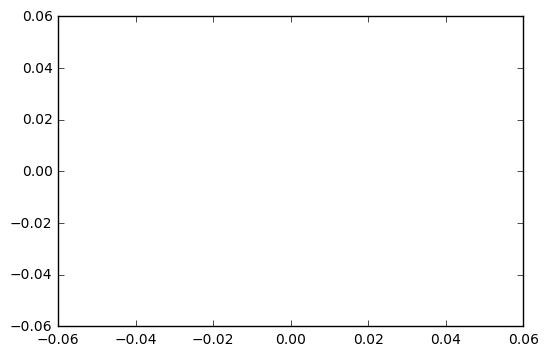

In [56]:
plt.plot(df[['Corrected Water Temp:', 'Battery Park Water Temp']].dropna())

In [57]:
df.to_csv('../Created CSVs/Cleaned_For_Analysis_All_Data.csv')

In [58]:
#pd.options.display.max_rows = 999

In [59]:
#Looks good!
#df[['Salinity', 'Corrected Salinity', 'DO', 'Corrected DO', 'pH', 'Corrected pH', 'Quantity', 'Corrected Quantity', '# Hauls', 'Corrected # Hauls', 'Water Temp:', 'Corrected Water Temp:']]

In [60]:
#checks out!
#df[['Date','Corrected Quantity','Common Name', 'Corrected Common Name', 'Grouped Corrected Common Name']]